# Figures for paper — now with diffusion mapping!

In [1]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [48]:
# Import local code
import sys
sys.path.append('../code')
from gradientVersion import *
from processing_helpers import *
from analysis_helpers import *
from triplets import *
from mri_maps import *
from enrichments import *
from brainspan import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");
%R source("../code/enrichmentsPlots.R");
%R source("../code/plot_maps.R");
%R source("../code/brainspanPlots.R");

---

## Set gradient version

In [62]:
pca = gradientVersion(approach='pca').fit('hcp_base')
# dm_hcp_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_ds9')
# dm_hcp_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3donors_ds5')
dm_dk_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('dk_ds9')

New gradients version: method=pca, kernel=None, data=hcp_base
New gradients version: method=dm, kernel=normalized_angle, data=dk_ds9


## 1 — Distributions

In [90]:
counts_hcp = pd.read_csv("../outputs/counts_hcp.csv", index_col=0)
stability = pd.read_csv("../outputs/stability_hcp_ranked.csv", index_col=0)
donor_counts = (counts_hcp!=0).sum(axis=1)[:180].rename('count').to_frame()

In [92]:
stability['ds'].quantile(.9)

0.3859072493003411

## 1 — PC brains

In [133]:
hcp_scores = (pd.concat({
    'PCA, all genes and regions': pca.scores * [1,-1,1,1,1], # flip G2
    'DM, only top 10% DS genes,\nall regions': dm_hcp_ds9.scores * [1,-1,1,1,1], # flip G2
    'DM, top 50% DS genes,\nonly 3+ donor regions': dm_hcp_3d_ds5.scores,
})
        .groupby(level=0).apply(lambda x: (x-np.mean(x))/np.std(x))
        .reset_index(level=0).rename({'level_0':'version'},axis=1)
        .join(get_labels_hcp())
         )

In [64]:
dk_scores = (dm_dk_ds9.scores
        .apply(lambda x: (x-np.mean(x))/np.std(x))
        .assign(version='DK atlas')
        .join(get_labels_dk())
         )

## 1 — Triplets filtering

Load triplets data from pickles since triplets are slow to compute

In [37]:
triplets_hcp = load_pickle('triplets_hcp')
triplets_hcp_3donors = load_pickle('triplets_hcp_3donors')

In [66]:
triplets_pca = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp, use_gradientVersion=True, approach='pca'), with_coefs=False)
triplets_dm = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp, use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=1), with_coefs=False)
triplets_dm_3d = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp_3donors, use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=1), with_coefs=False)

In [148]:
triplets_dict = {
    'PCA': triplets_pca, 
    'Diffusion Maps (DM)': triplets_dm,
    # 'Diffusion Map, 2+ donors/region': triplets_dm_2d,
    'DM, only 3+ donors regions': triplets_dm_3d
}

triplets_plot_v2 = (pd.concat(triplets_dict)
 .reset_index(0)
 .rename({'level_0':'method', 'version':'DS'}, axis=1)
 .assign(method = lambda x: pd.Categorical(x['method'], ordered=True, categories=triplets_dict.keys()))
                   )

df_triplets_highlight = pd.DataFrame({'method': triplets_dict.keys(), 'DS':[0,.9,.5]}).assign(method = lambda x: pd.Categorical(x['method'], ordered=True, categories=triplets_dict.keys()))

# Fig 1

Message: With careful processing, PC2 and PC3 of the AHBA are robust and generalizable.

In [150]:
%%R -i triplets_plot_v2
triplets_plot_v2 %>%
    filter(component <= 3) %>%
    group_by(method, component, DS) %>%
    mutate(ymin = corr_abs - 2*sd(corr_abs)/10, 
           ymax = corr_abs + 2*sd(corr_abs)/10
           )

# A tibble: 900 × 9
# Groups:   method, component, DS [90]
   method how              DS component pair       corr corr_abs    ymin   ymax
   <ord>  <chr>         <dbl> <chr>     <chr>     <dbl>    <dbl>   <dbl>  <dbl>
 1 PCA    Region scores   0   1         012-345  0.774    0.774  0.742   0.807 
 2 PCA    Region scores   0   2         012-345  0.0414   0.0414 0.00564 0.0771
 3 PCA    Region scores   0   3         012-345  0.246    0.246  0.228   0.264 
 4 PCA    Region scores   0.1 1         012-345  0.798    0.798  0.764   0.832 
 5 PCA    Region scores   0.1 2         012-345  0.314    0.314  0.275   0.354 
 6 PCA    Region scores   0.1 3         012-345  0.0611   0.0611 0.0468  0.0753
 7 PCA    Region scores   0.2 1         012-345 -0.814    0.814  0.778   0.851 
 8 PCA    Region scores   0.2 2         012-345  0.0600   0.0600 0.0226  0.0975
 9 PCA    Region scores   0.2 3         012-345 -0.0599   0.0599 0.0425  0.0774
10 PCA    Region scores   0.3 1         012-345 -0.830    0.8

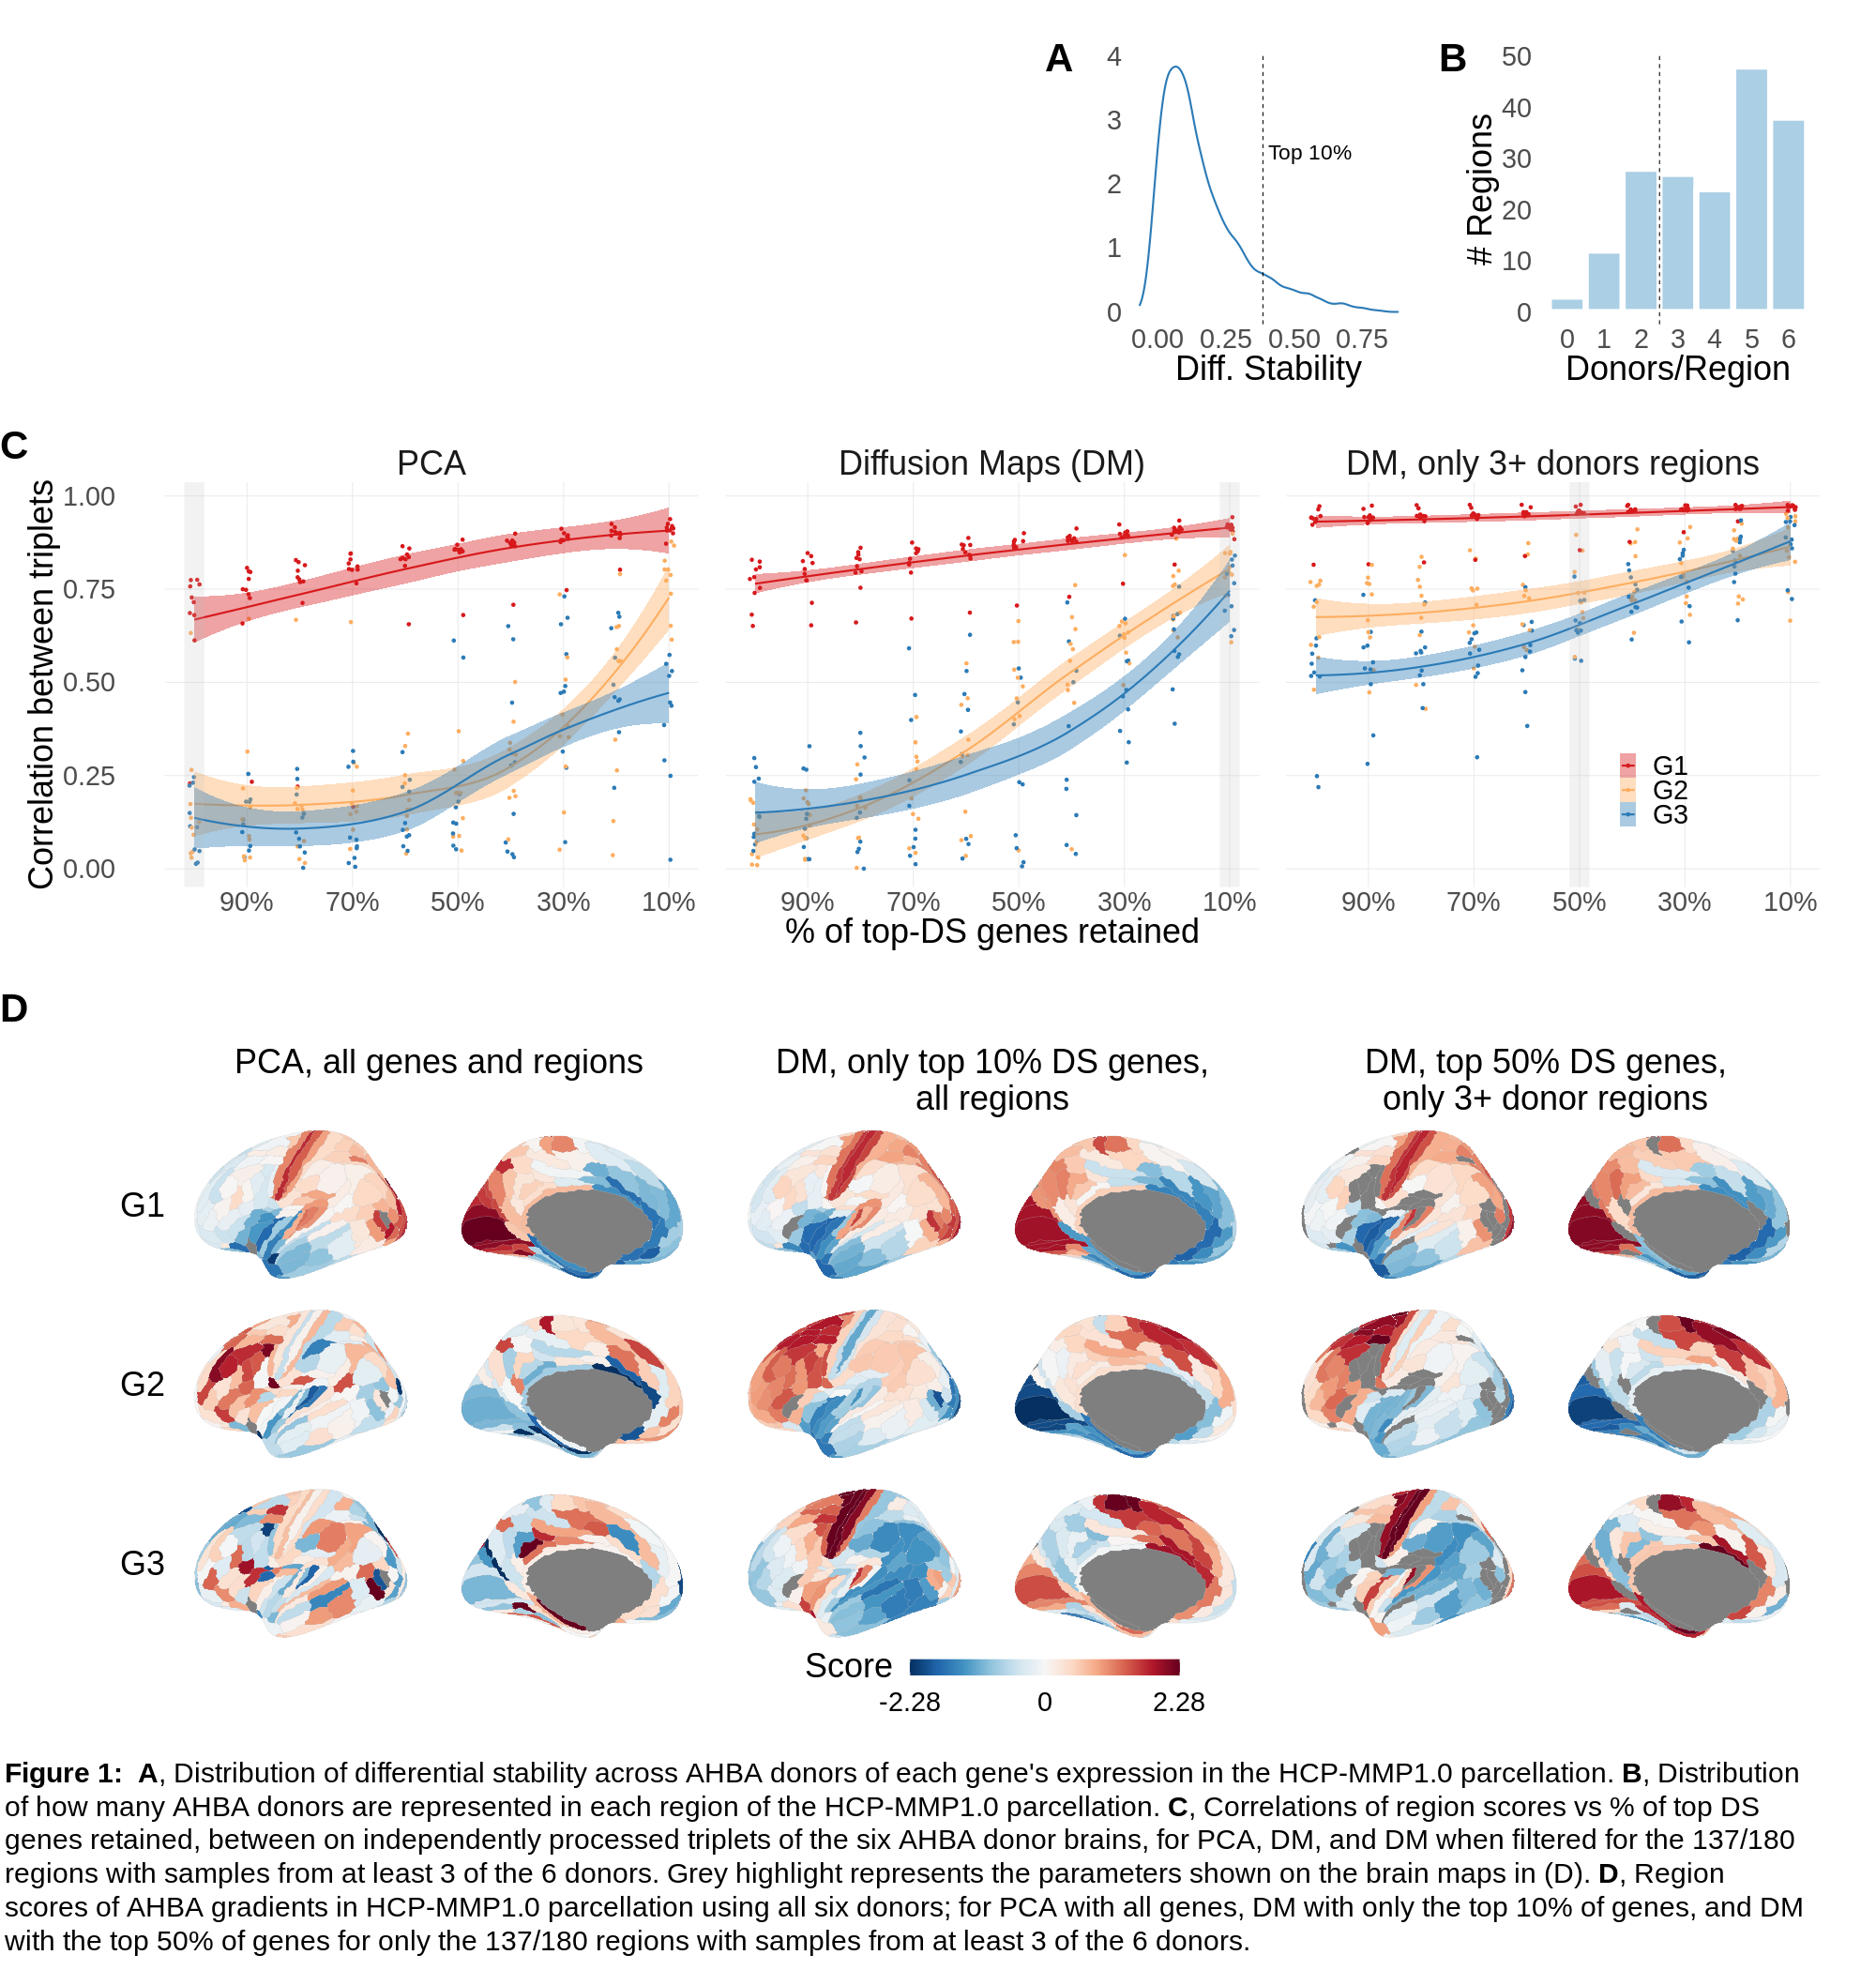

In [157]:
%%R -w 2000 -h 2100 -i triplets_plot_v2 -i donor_counts -i stability -i hcp_scores -i dk_scores -i df_triplets_highlight
source("../code/Rplots.R")
source("../code/brainspanPlots.R")

g0 <- plot_spacer()
g1a <- plot_ds_dist_hcp(stability)
g1b <- plot_dist_donors_hcp(donor_counts)
g2 <- plot_triplets_v2(triplets_plot_v2)
g3 <- plot_hcp(hcp_scores, three=T, switch='y') + 
    theme(legend.position='bottom') + guides(fill=guide_colorbar(title='Score', barwidth=20, title.vjust=1.2))
# theme(legend.position=c(1.05,.5)) + guides(fill=guide_colorbar(title='Score', barheight=15))
# g3b <- plot_dk(dk_scores, three=T, flip=F) + guides(fill='none') + theme(strip.text.y = element_blank())

caption <- paste("**Figure 1:**",
                "**A**, Distribution of differential stability across AHBA donors of each gene's expression in the HCP-MMP1.0 parcellation.",
                "**B**, Distribution of how many AHBA donors are represented in each region of the HCP-MMP1.0 parcellation.",
                "**C**, Correlations of region scores vs % of top DS genes retained, between on independently processed triplets of the six AHBA donor brains, for PCA, DM, and DM when filtered for the 137/180 regions with samples from at least 3 of the 6 donors.",
                 "Grey highlight represents the parameters shown on the brain maps in (D).",
                "**D**, Region scores of AHBA gradients in HCP-MMP1.0 parcellation using all six donors; for PCA with all genes, DM with only the top 10% of genes, and DM with the top 50% of genes for only the 137/180 regions with samples from at least 3 of the 6 donors."
                # "**E**, Region scores of AHBA in Desikan-Killiany parcellation, for the top 10% of genes."
)


plot <- (
        # First row
        ( (g0 | g1a | g1b) + plot_layout(widths=c(3,1,1))) /
        # Second row
        (g2 + geom_vline(data=df_triplets_highlight, aes(xintercept=DS), size=10, alpha=.2, color='grey')) /
        # Third row
        # ((g3 | g3b) + plot_layout(widths=c(2,1), guides='collect') & theme(legend.position='bottom'))
        g3
    ) + plot_layout(heights=c(2,3,4)) 

themed <- plot & theme(
    text=element_text(size=36), 
    strip.text=element_text(size=36),
    strip.text.x=element_text(size=36),
    strip.text.y=element_text(size=36),
    plot.margin = margin(t=10, r=30, b=10, l=0, "pt"),
    plot.tag = element_text(size=42, face='bold', vjust=-2)
)
    
annotated <- themed + plot_annotation(
  tag_level='A',
  caption = caption,
  theme = theme(plot.caption = element_textbox_simple(size = 30, padding = unit(c(40, 5, 5, 5), "pt")))
)
annotated

---

## 2 — Brainspan mapping

In [158]:
bs_cortex_mapping = get_bs_cortex_mapping()
hcp_bs_mapping = get_hcp_bs_mapping(bs_cortex_mapping)

## 2 — Brainspan development

In [91]:
bs_dir = "../data/brainspan-data/gene_matrix_rnaseq/"
bs_exp, bs_col, bs_row = get_brainspan(bs_dir)
bs_clean = clean_brainspan(bs_exp, bs_col, bs_row, bs_cortex_mapping)
bs_agg = aggregate_brainspan_by_age(bs_clean)

_, pcs_cortex = get_mapped_pcs(hcp_version, hcp_base, hcp_bs_mapping)
bs_pcs = compute_brainspan_pc_scores(bs_agg, hcp_version, bs_cortex_mapping)

In [95]:
age_groups = get_age_groups()
bs_pcs_corr = correlate_bs_pcs(bs_pcs, pcs_cortex, age_groups=age_groups)

## 4 — Brainspan adult correlation

In [96]:
cortex_scores, cortex_corrs = get_cortex_scores(bs_pcs, pcs_cortex, age_groups, bs_cortex_mapping)

# Fig 4

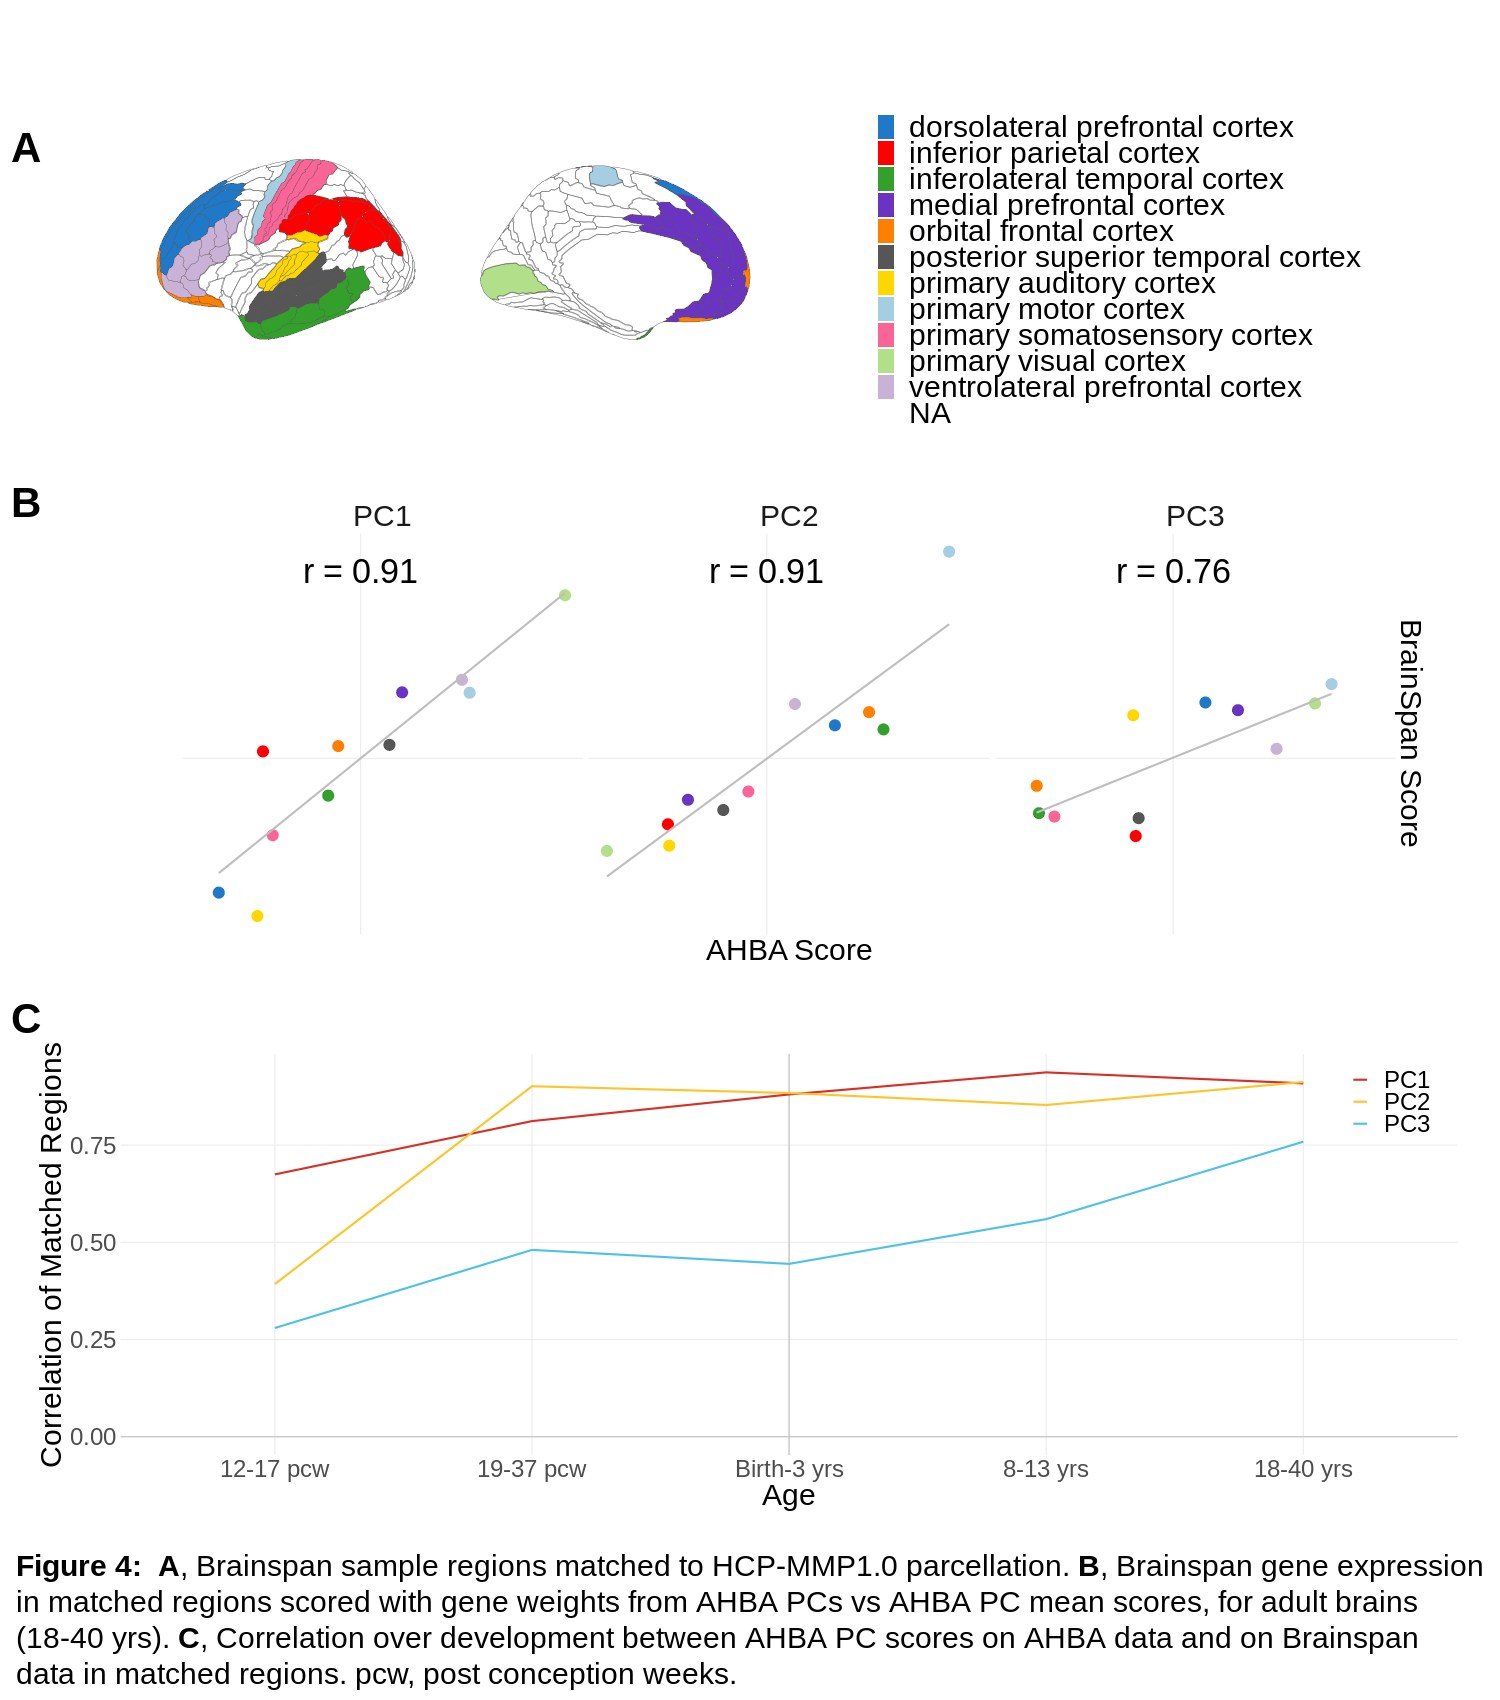

In [97]:
%%R -w 1500 -h 1700 -i bs_pcs_corr -i cortex_scores -i cortex_corrs -i hcp_bs_mapping
source("../code/brainspanPlots.R")
g1 <- plot_bs_mapping(hcp_bs_mapping)
g2 <- plot_ahba_bs_scatter(cortex_scores, cortex_corrs)
g3 <- plot_bs_pcs_corr(bs_pcs_corr)

# plot <- (
#     ((g1 + theme(legend.text = element_text(size=30)) | g2) + plot_layout(widths=c(4,5))) / 
#     g3
# ) + plot_layout(heights=c(2,3))

# layout <- "
# AA##
# BBBB
# CCCC
# "
# plot <- g1 + g2 + g3 + plot_layout(design = layout, widths=1)

plot <- (
    ((g1 + theme(legend.text = element_text(size=30), legend.position=c(1.5, .5))) | plot_spacer()) / 
     g2 / 
     g3
)


caption <- paste("**Figure 4:**",
                 "**A**, Brainspan sample regions matched to HCP-MMP1.0 parcellation.",
                 "**B**, Brainspan gene expression in matched regions scored with gene weights from AHBA PCs vs AHBA PC mean scores, for adult brains (18-40 yrs).",
                 "**C**, Correlation over development between AHBA PC scores on AHBA data and on Brainspan data in matched regions. pcw, post conception weeks."
                )

themed <- plot & theme(
    text=element_text(size=30), 
    strip.text = element_text(size=30),
    plot.tag = element_text(size=42, face='bold', vjust=-2))
annotated <- themed + plot_annotation(
  tag_level='A',
  caption = caption,
  theme = theme(plot.caption = element_textbox_simple(size = 30, padding = unit(c(40, 5, 5, 5), "pt")))
)
annotated

## 2 — Other maps

In [99]:
scores = hcp_base.score_from(hcp_version).iloc[:,:3].apply(lambda x: (x-np.mean(x))/np.std(x)).rename_axis('region')
scores_plot = scores.join(get_labels_hcp())
maps = get_maps()
corrs = get_corrs(scores, maps, method='pearson')
# generate_spins(maps, 1000, '../outputs/spin_maps_v2_1000.npy')
# generate_surrogates(maps, 1000, '../outputs/sim_maps_v2_1000.npy')
# spin_maps_1000 = np.load("../outputs/spin_maps_v2_1000.npy")
sim_maps_1000 = np.load("../outputs/sim_maps_v2_1000.npy")
null_corrs = corr_nulls_from_maps(sim_maps_1000, scores, maps, method='pearson')
null_p = get_null_p(corrs, null_corrs)

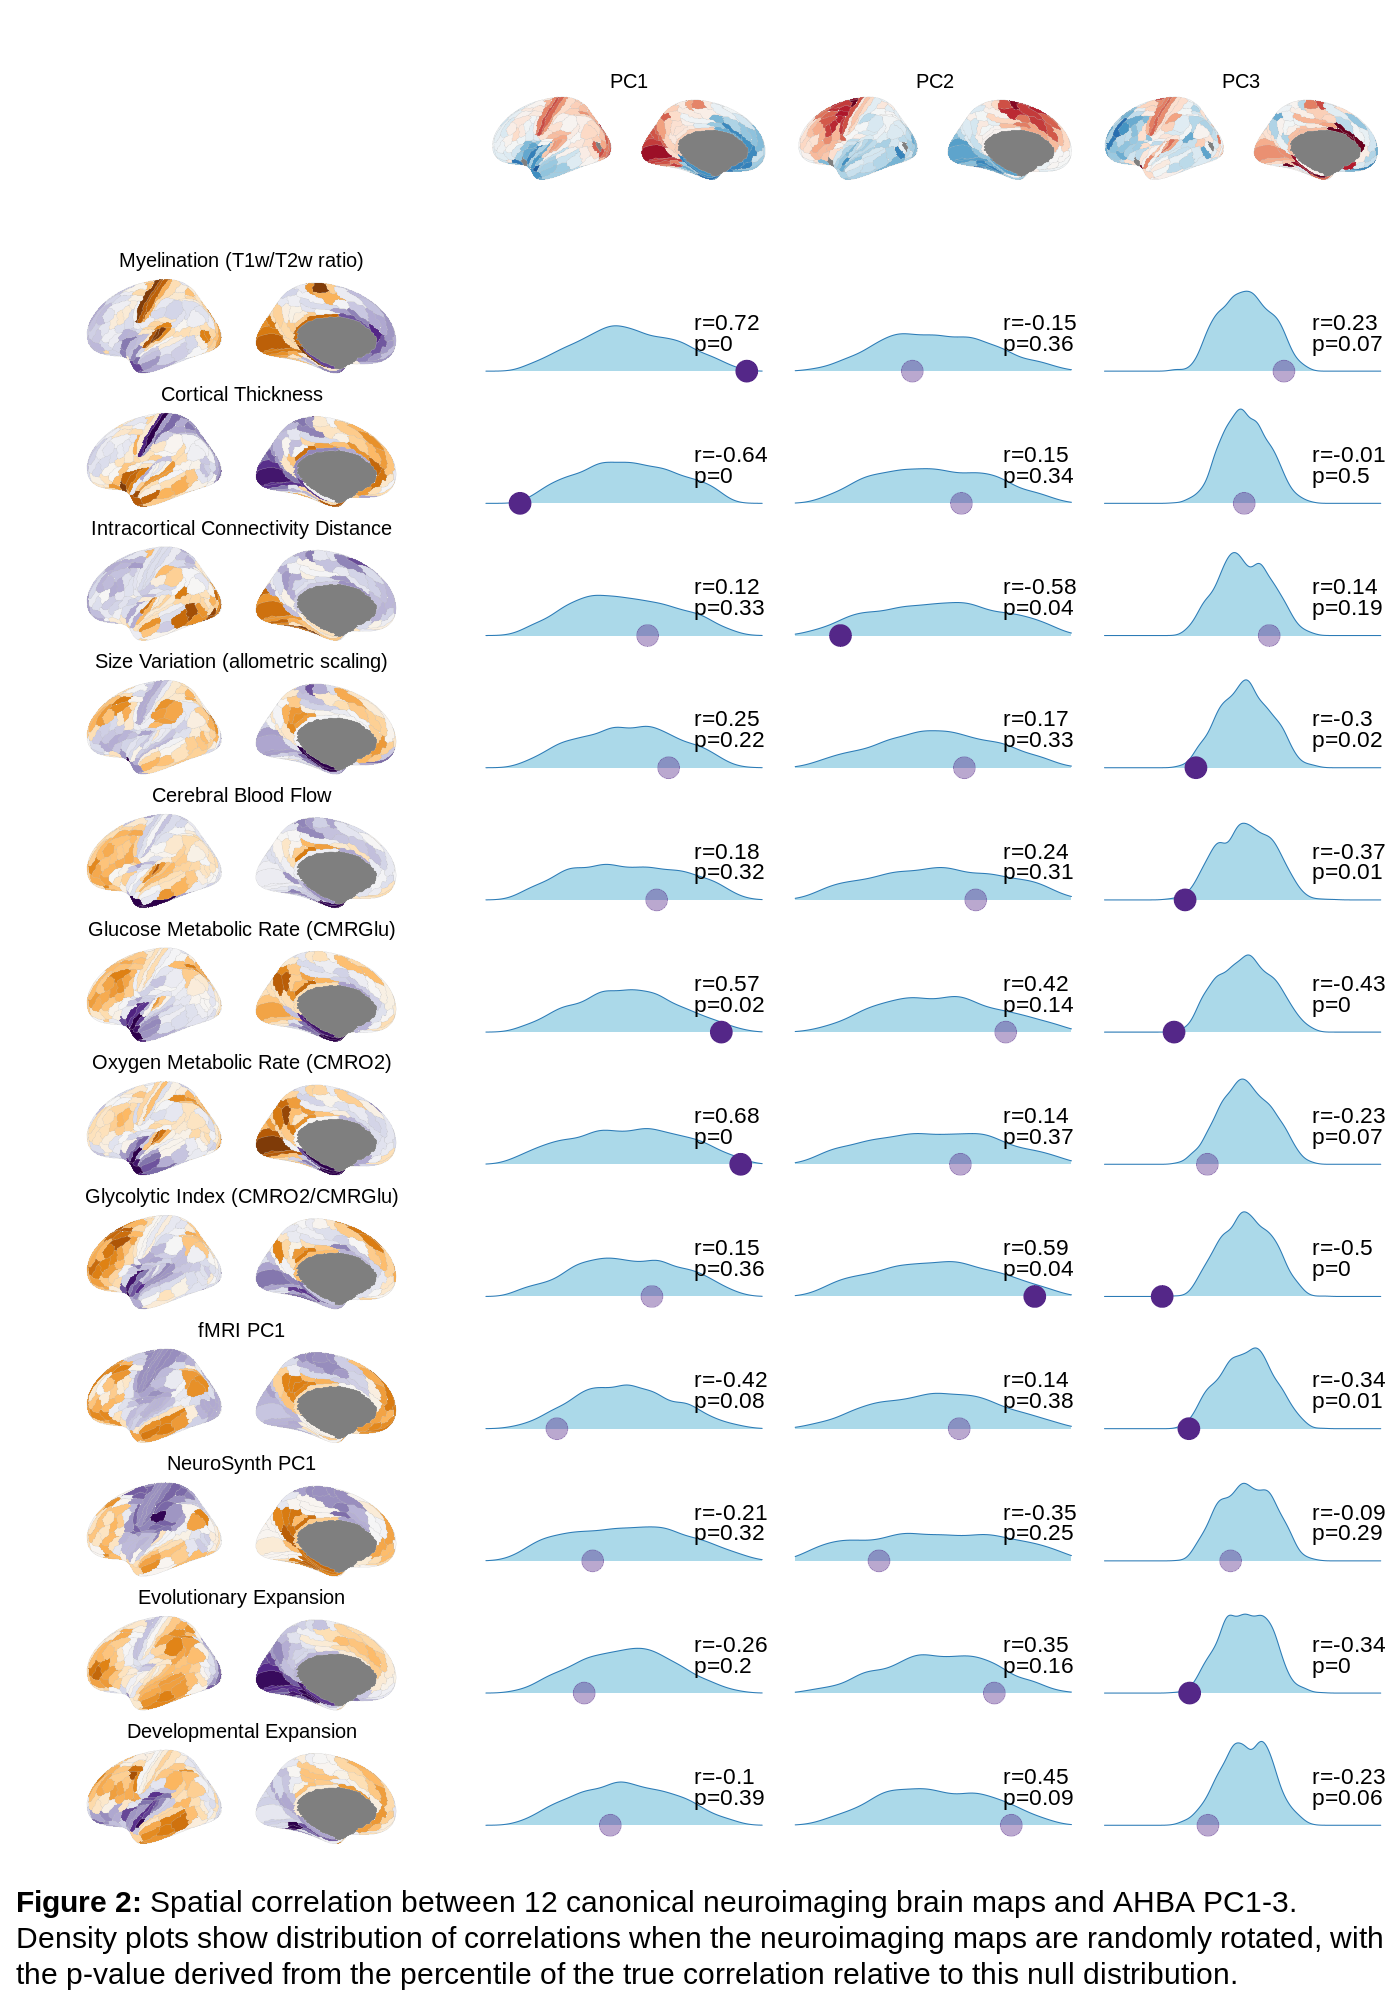

In [107]:
%%R  -w 1400 -h 2000 -i scores_plot -i maps -i corrs -i null_corrs -i null_p
source("../code/plot_maps.R")
source("../code/brainPlots.R")
g1 <- plot_null_corrs(corrs, null_corrs, null_p)
g2 <- plot_hcp_wide(scores_plot, spacing=0) + guides(fill='none')
g3 <- plot_maps(maps, colors=rev(brewer.puor(100)), ncol=1) + guides(fill='none')

plot <- (
    ((plot_spacer() | g2) + plot_layout(widths=c(1,2))) / 
    ((g3 | g1) + plot_layout(widths=c(1,2)))
) + plot_layout(heights=c(1,12))


caption <- paste("**Figure 2:**", "Spatial correlation between 12 canonical neuroimaging brain maps and AHBA PC1-3. Density plots show distribution of correlations when the neuroimaging maps are randomly rotated, with the p-value derived from the percentile of the true correlation relative to this null distribution."
)

themed <- plot & theme(
    text=element_text(size=36),
    # strip.text=element_text(size=36),
    # strip.text.x=element_text(size=36)
    # strip.text.y=element_text(size=36)
    # plot.tag = element_text(size=42, face='bold', vjust=-2)
)
    
annotated <- themed + plot_annotation(
  # tag_level='A',
  caption = caption,
  theme = theme(plot.caption = element_textbox_simple(size = 30, padding = unit(c(40, 5, 5, 5), "pt")))
)
annotated

## 3 — Gene weight vs DS

In [86]:
coefs_ds = (hcp_version.coefs.T
            .iloc[:,:3].set_axis(['PC1','PC2','PC3'],axis=1)
            .join(stability))

## 3 — Cell type enrichment

In [87]:
cell_genes = get_cell_genes()
gene_masks = match_cell_genes(cell_genes, hcp_version)
weights = hcp_version.coefs.iloc[:3,:].T
null_weights = shuffle_gene_weights(weights, n=10000)

true_scores, null_scores = compute_cell_scores(
    weights, null_weights, gene_masks, how='median')

order = ['Neuro', 'Oligo', 'Astro', 'Micro', 'Endo', 'OPC']
null_p = compute_null_p(true_scores, null_scores, signed=False).loc[order]

# Fig 3 — Gene enrichments

In [88]:
scores_wide = (hcp_base.score_from(hcp_version)
               .apply(lambda x: (x-np.mean(x))/np.std(x))
               .iloc[:,:3].join(get_labels_hcp()))

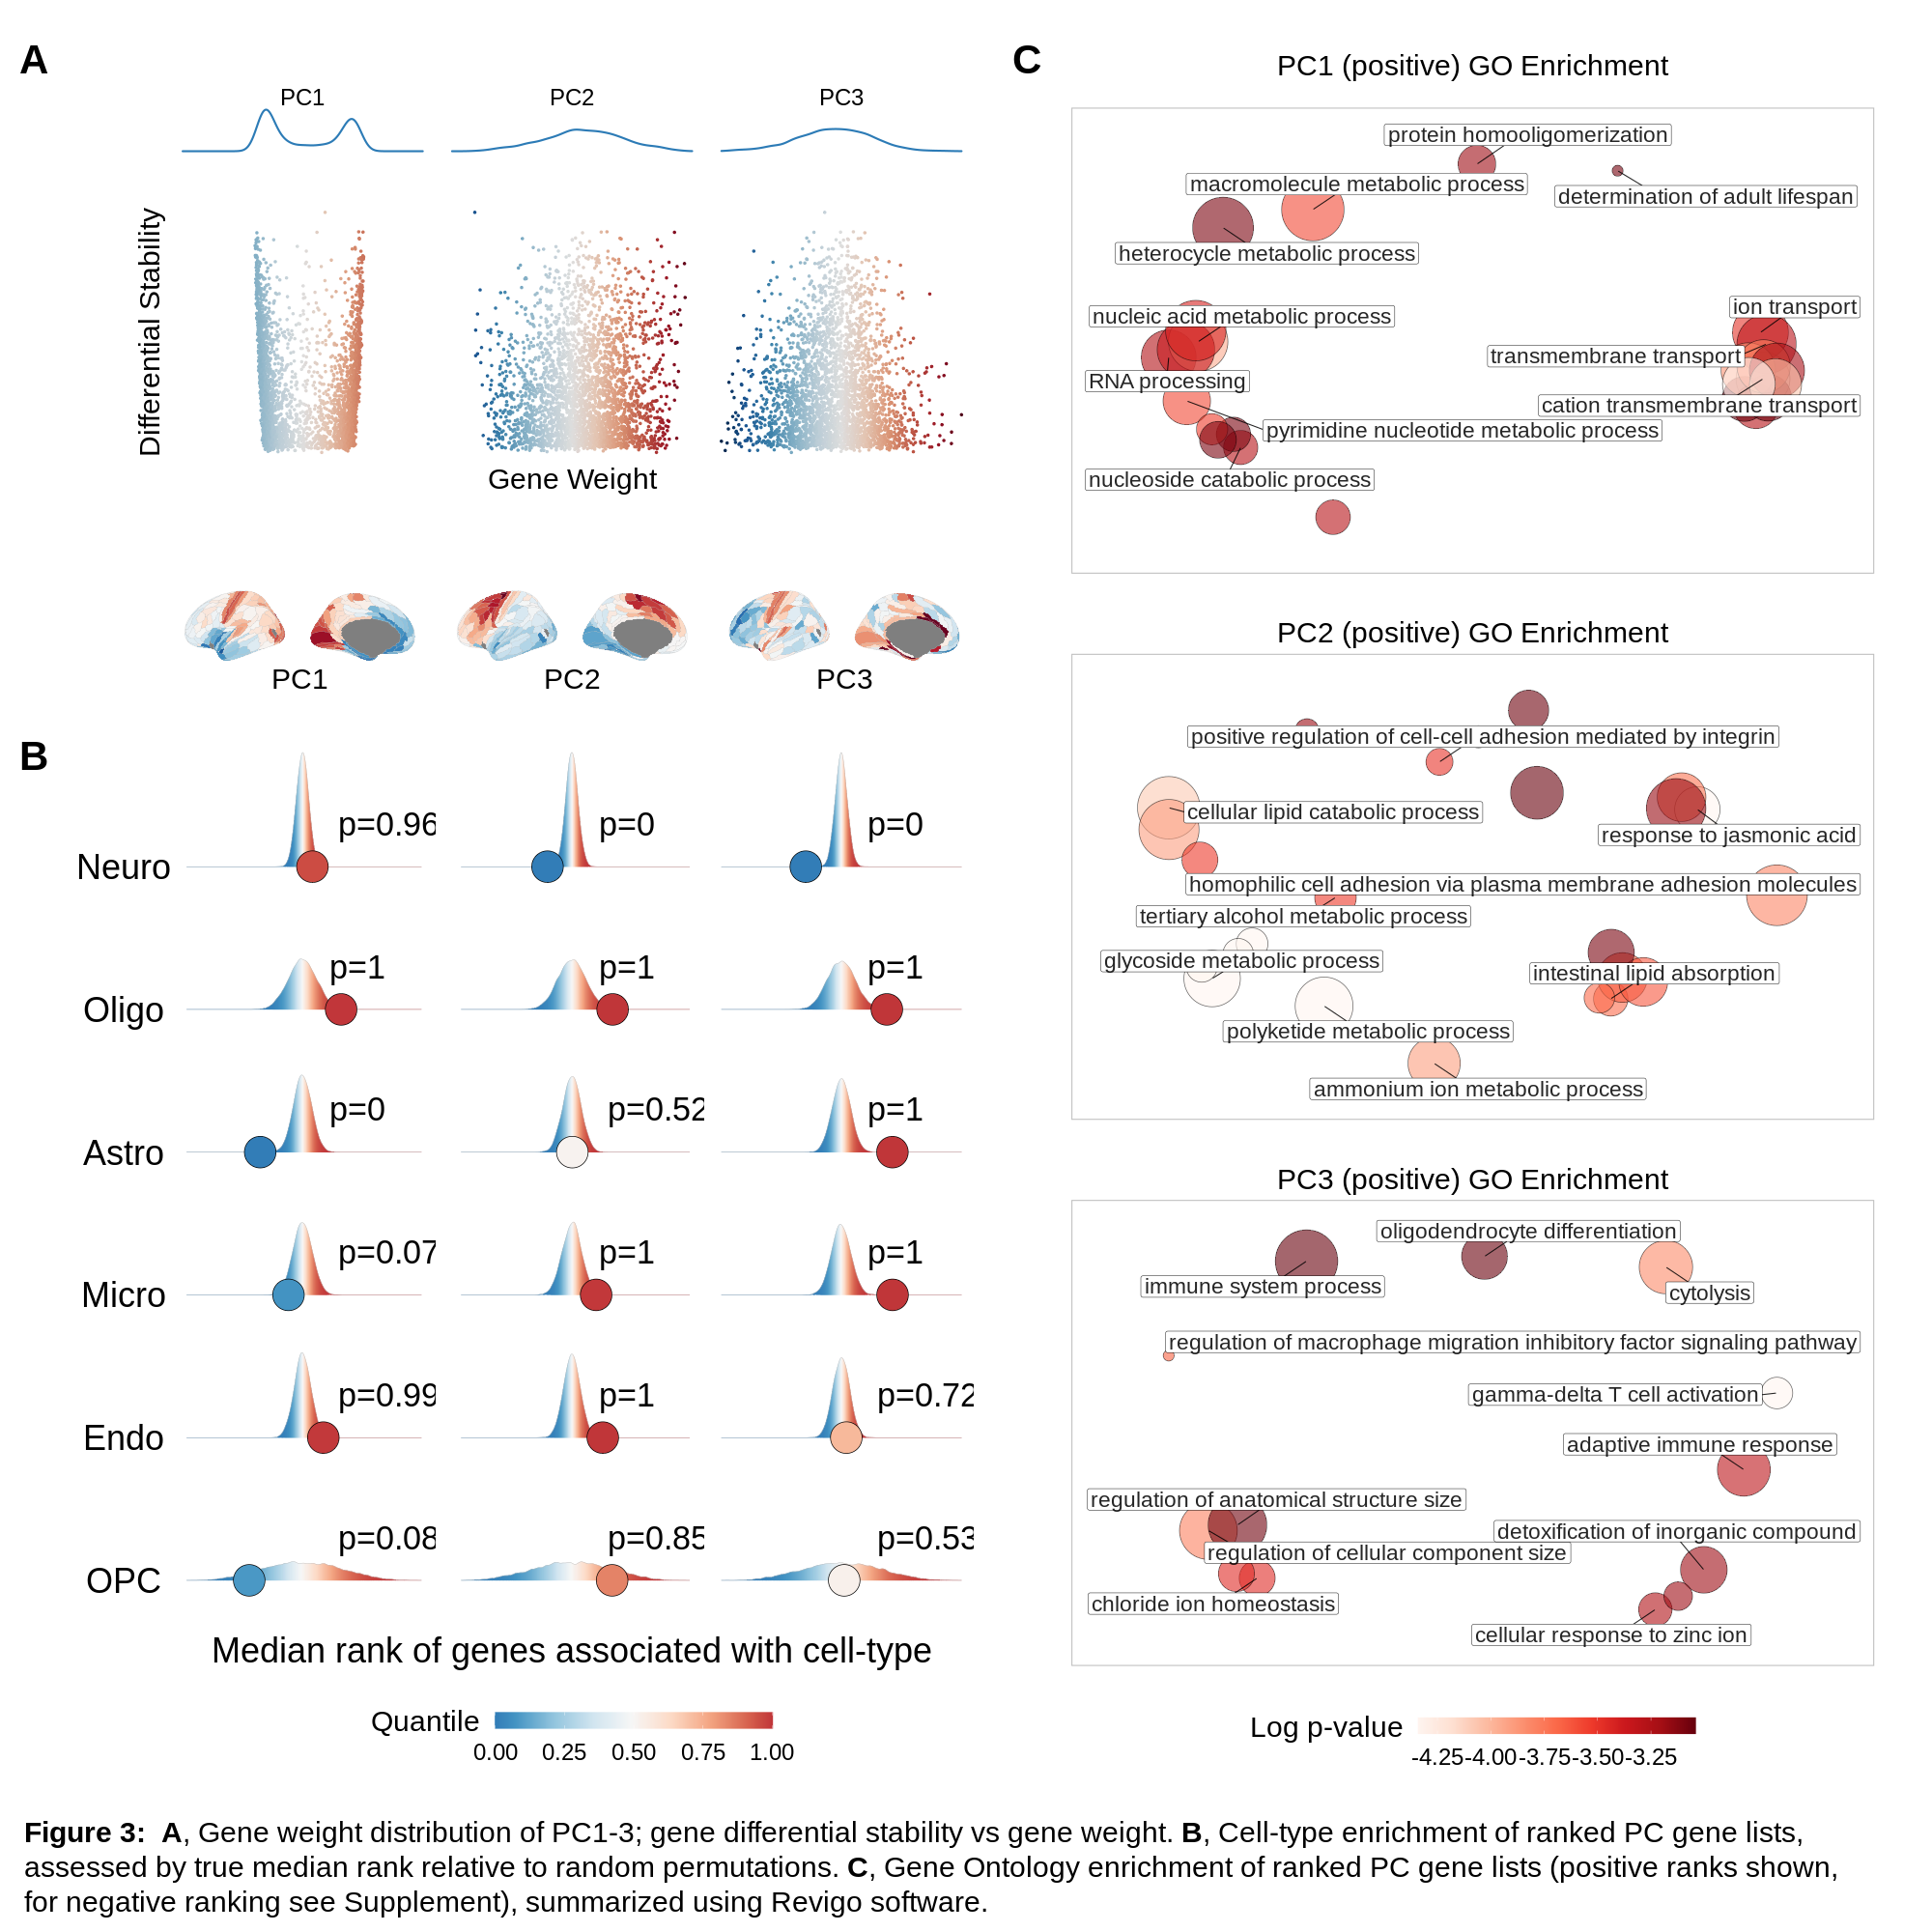

In [89]:
%%R  -w 2000 -h 2000 -i scores_wide -i coefs_ds -i true_scores -i null_scores -i null_p
source("../code/Rplots.R")
source("../code/enrichmentsPlots.R")

g0 <- plot_hcp_wide(scores_wide, spacing=1) + facet_grid(.~component, switch='x') +
    guides(fill='none') + theme(strip.text.x = element_text(size=30))

g1 <- plot_coefs_ds(coefs_ds)
g1a <- plot_coefs_dist(coefs_ds)
g2 <- plot_cell_enrichment(true_scores, null_scores, null_p, how='median')

r1 <- plot_revigo_data("../outputs/revigo_pc1pos.R", text_threshold=.6, 'PC1 (positive) GO Enrichment') + xlab('') + ylab('')
r2 <- plot_revigo_data("../outputs/revigo_pc2pos.R", text_threshold=.1, 'PC2 (positive) GO Enrichment') + xlab('')
r3 <- plot_revigo_data("../outputs/revigo_pc3pos.R", text_threshold=.6, 'PC3 (positive) GO Enrichment') + ylab('')


plot <- (
            (
                 g1a / 
                 (g1 + plot_layout(tag_level='new')) / 
                 (g0 + plot_layout(tag_level='new')) /
                 g2
            ) + plot_layout(heights=c(1,7,2,20))
        ) | (
            (r1 + theme(legend.position='none')) /
            (r2 + plot_layout(tag_level='new') + theme(legend.position='none') ) / 
            (r3 + plot_layout(tag_level='new') + theme(legend.position='bottom') ) 
        )

themed <- plot & theme(
    text=element_text(size=30),
    plot.margin = margin(t=10, r=30, b=10, l=10, "pt"),
    plot.tag = element_text(size=42, face='bold', vjust=-2)
)

caption <- paste("**Figure 3:**",
                "**A**, Gene weight distribution of PC1-3; gene differential stability vs gene weight.",
                "**B**, Cell-type enrichment of ranked PC gene lists, assessed by true median rank relative to random permutations.",
                "**C**, Gene Ontology enrichment of ranked PC gene lists (positive ranks shown, for negative ranking see Supplement), summarized using Revigo software."
)

annotated <- themed + plot_annotation(
  tag_level='A',
  caption = caption,
  theme = theme(plot.caption = element_textbox_simple(size = 30, padding = unit(c(40, 5, 5, 5), "pt")))
)
annotated

# Fig 3 in DK

In [64]:
dk_version = dk_ds5
stability_dk = pd.read_csv("../outputs/stability_dk.csv", index_col=0).set_axis(['DS'], axis=1)

In [65]:
coefs_ds = (dk_version.coefs.T
            .iloc[:,:3].set_axis(['PC1','PC2','PC3'],axis=1)
            .join(stability_dk))

In [66]:
cell_genes = get_cell_genes()
gene_masks = match_cell_genes(cell_genes, dk_version)
weights = dk_version.coefs.iloc[:3,:].T
null_weights = shuffle_gene_weights(weights, n=10000)

true_scores, null_scores = compute_cell_scores(
    weights, null_weights, gene_masks, how='median')

order = ['Neuro', 'Oligo', 'Astro', 'Micro', 'Endo', 'OPC']
null_p = compute_null_p(true_scores, null_scores, signed=False).loc[order]

In [70]:
scores_wide = (dk_ds5.scores
               .apply(lambda x: (x-np.mean(x))/np.std(x))
               .iloc[:,:3].join(get_labels_dk()))

In [81]:
%%R -i scores_wide
df <- scores_wide %>% 
    rename('PC1'='0', 'PC2'='1', 'PC3'='2') %>% 
    gather('component', 'score', -label) %>%
    group_by(component)

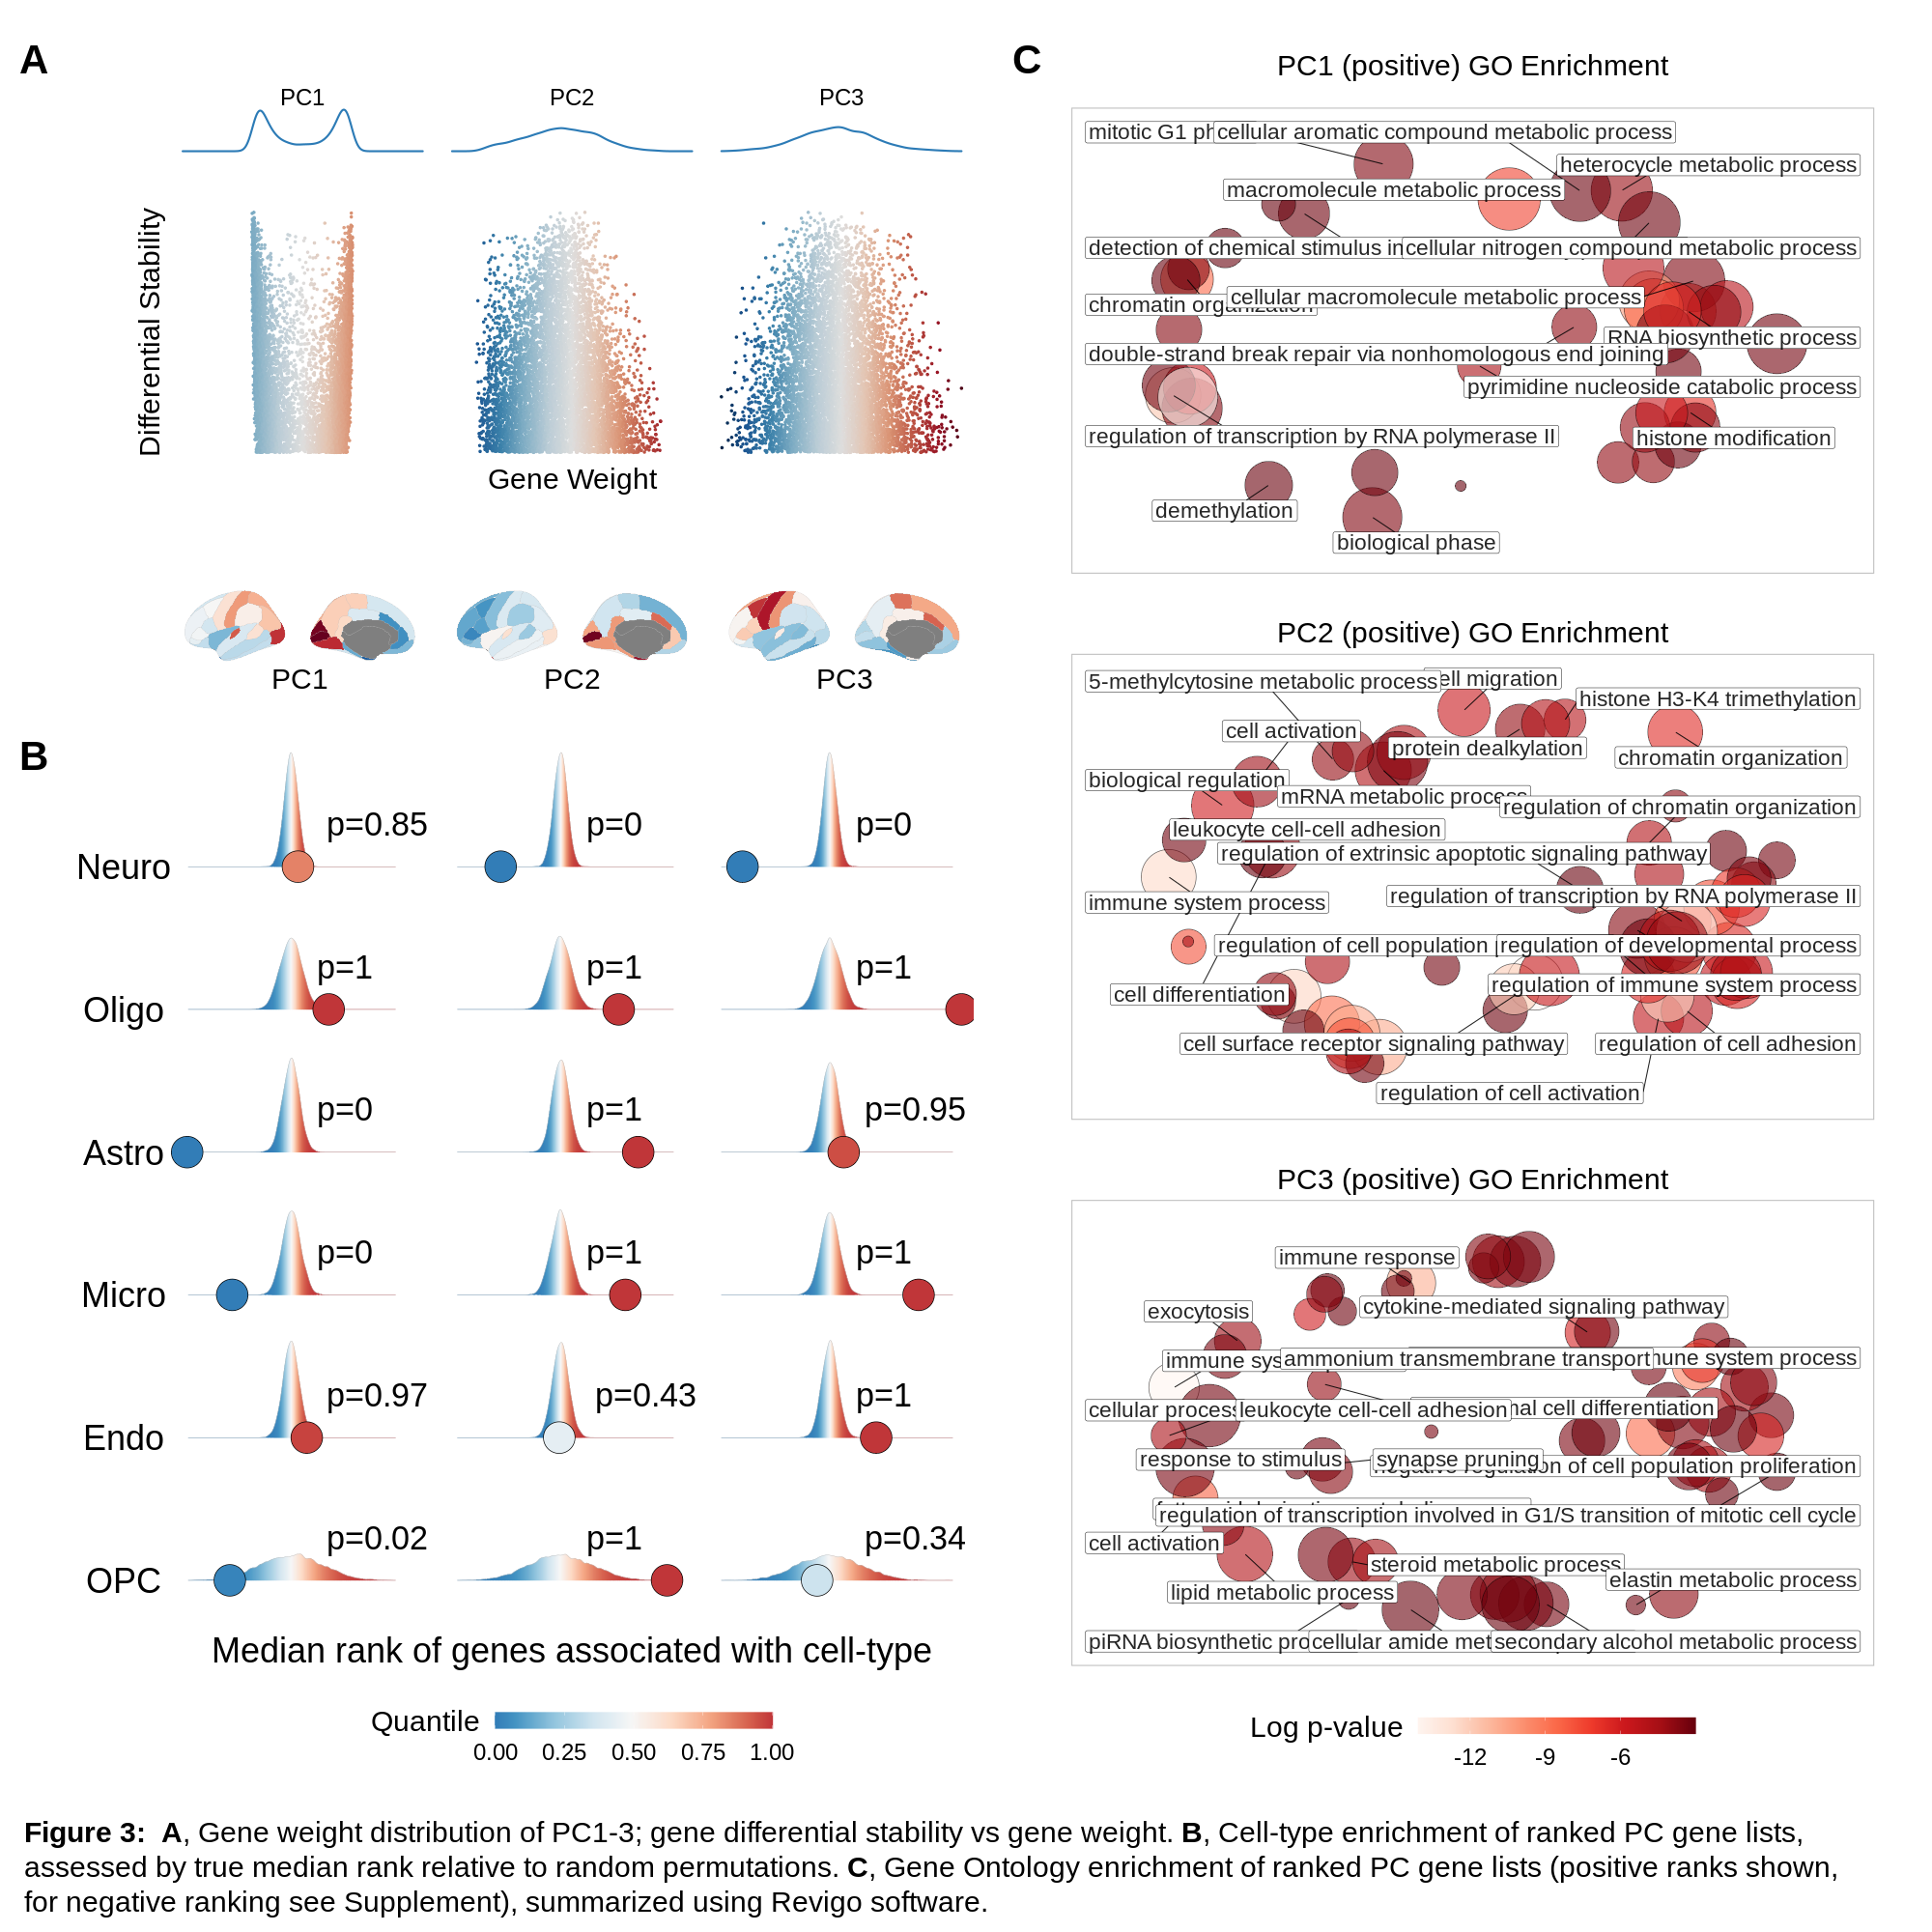

In [85]:
%%R  -w 2000 -h 2000 -i scores_wide -i coefs_ds -i true_scores -i null_scores -i null_p
source("../code/Rplots.R")
source("../code/brainPlots.R")
source("../code/enrichmentsPlots.R")

g0 <- plot_dk_wide(scores_wide, spacing=1) + facet_grid(.~component, switch='x') +
    guides(fill='none') + theme(strip.text.x = element_text(size=30))

g1 <- plot_coefs_ds(coefs_ds)
g1a <- plot_coefs_dist(coefs_ds)
g2 <- plot_cell_enrichment(true_scores, null_scores, null_p, how='median')

r1 <- plot_revigo_data("../outputs/revigo_dk_pc1.R", text_threshold=.3, 'PC1 (positive) GO Enrichment') + xlab('') + ylab('')
r2 <- plot_revigo_data("../outputs/revigo_dk_pc2.R", text_threshold=.3, 'PC2 (positive) GO Enrichment') + xlab('')
r3 <- plot_revigo_data("../outputs/revigo_dk_pc3.R", text_threshold=.3, 'PC3 (positive) GO Enrichment') + ylab('')


plot <- (
            (
                 g1a / 
                 (g1 + plot_layout(tag_level='new')) / 
                 (g0 + plot_layout(tag_level='new')) /
                 g2
            ) + plot_layout(heights=c(1,7,2,20))
        ) | (
            (r1 + theme(legend.position='none')) /
            (r2 + plot_layout(tag_level='new') + theme(legend.position='none') ) / 
            (r3 + plot_layout(tag_level='new') + theme(legend.position='bottom') ) 
        )

themed <- plot & theme(
    text=element_text(size=30),
    plot.margin = margin(t=10, r=30, b=10, l=10, "pt"),
    plot.tag = element_text(size=42, face='bold', vjust=-2)
)

caption <- paste("**Figure 3:**",
                "**A**, Gene weight distribution of PC1-3; gene differential stability vs gene weight.",
                "**B**, Cell-type enrichment of ranked PC gene lists, assessed by true median rank relative to random permutations.",
                "**C**, Gene Ontology enrichment of ranked PC gene lists (positive ranks shown, for negative ranking see Supplement), summarized using Revigo software."
)

annotated <- themed + plot_annotation(
  tag_level='A',
  caption = caption,
  theme = theme(plot.caption = element_textbox_simple(size = 30, padding = unit(c(40, 5, 5, 5), "pt")))
)
annotated

---

# Supplement

## 1 — Var explained

In [222]:
hcp_base.var_pct

array([0.1876432 , 0.10067362, 0.09006554, 0.06852596, 0.05254298])

In [223]:
hcp_3donors_ds8.var_pct

array([0.48161994, 0.10763054, 0.08151609, 0.03708704, 0.02723278])

---

# Other

In [17]:
scores = hcp_version.scores.iloc[:,:3].apply(lambda x: (x-np.mean(x))/np.std(x)).melt()

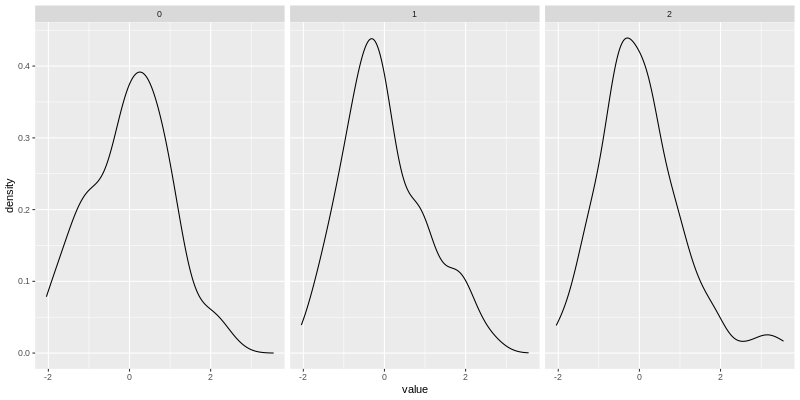

In [18]:
%%R -i scores -w 800 -h 400
ggplot(scores) + geom_density(aes(value)) + facet_wrap(~variable)

In [20]:
scores2 = hcp_version.scores.apply(lambda x: (x-np.mean(x))/np.std(x))
scores2 = pd.concat({
           '12':scores2.loc[:, [0,1]].set_axis(['x','y'],axis=1),
           '23':scores2.loc[:, [1,2]].set_axis(['x','y'],axis=1),
           '31':scores2.loc[:, [2,0]].set_axis(['x','y'],axis=1),
          }).reset_index(0)

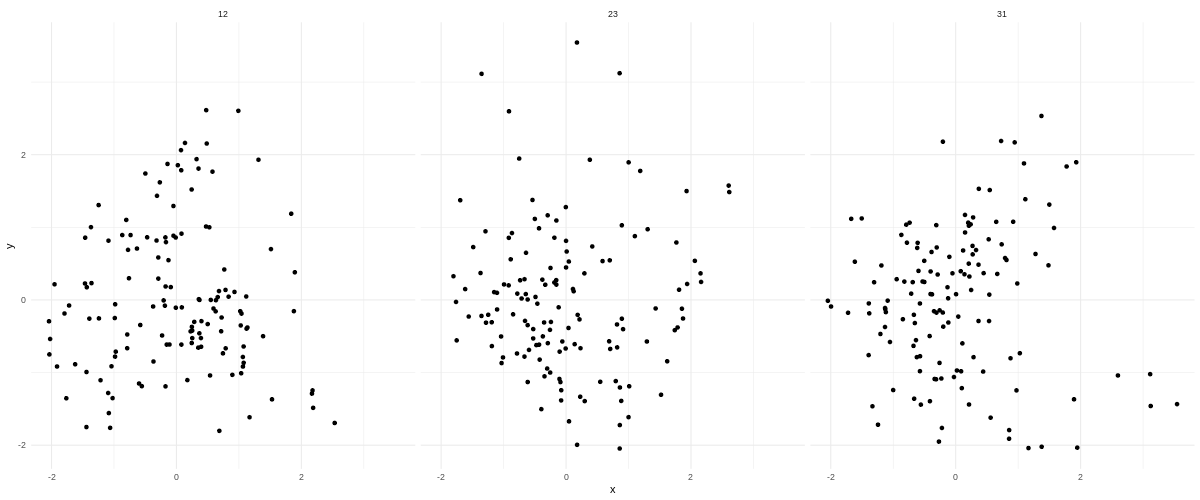

In [21]:
%%R -i scores2 -w 1200 -h 500
ggplot(scores2) +
facet_wrap(~level_0) +
geom_point(aes(x,y)) +
theme_minimal()

In [112]:
dk_scores

,0,1,2,3,4,version,label
label,,,,,,,
1,0.326372,-0.815002,-0.962059,0.095188,1.250977,DK atlas,lh_bankssts
2,-1.335551,1.240942,1.292200,-0.939137,-1.542608,DK atlas,lh_caudalanteriorcingulate
3,-0.009702,-1.302141,1.578381,-0.407937,-0.602979,DK atlas,lh_caudalmiddlefrontal
4,2.100754,0.870873,-0.633147,0.161308,-0.853242,DK atlas,lh_cuneus
5,-1.840884,1.929362,0.107826,-1.567812,-0.182591,DK atlas,lh_entorhinal
6,-0.394182,0.053072,-1.296331,0.379647,0.927848,DK atlas,lh_fusiform
7,0.614155,-0.264029,-0.447353,-0.114571,1.119628,DK atlas,lh_inferiorparietal
8,-0.532179,-0.153601,-1.067177,0.474469,1.284930,DK atlas,lh_inferiortemporal
9,0.426036,0.947594,0.169942,-1.049127,0.551339,DK atlas,lh_isthmuscingulate


In [160]:
replace_dict = {
    ' ': '',
    'Left':'lh_',
    'Right':'rh_',
    'cortex':'',
    'gyrus':'',
    'lobule':'',
    'superiortemporalsulcus':'sts'
    # 'medial_orbitofrontal':'medialorbitofrontal',
}

dk_mdd = (pd.read_csv("../data/Schmaal_MDD_thickness.csv")
          .assign(label = lambda x: x['label'].replace(replace_dict, regex=True))
          .assign(label = lambda x: x['label'].replace(replace_dict, regex=True)) # apply twice
          .iloc[:, :2]
          .set_axis(['label', 'd'], axis=1)
          .join(dk_scores.set_index('label').iloc[:,:3], on='label')
          .dropna()
         )
dk_mdd

,label,d,0,1,2
0,lh_medialorbitofrontal,-0.134,-0.986068,-0.659707,-0.798255
2,lh_rostralanteriorcingulate,-0.130,-1.346376,0.579658,-0.704077
4,lh_fusiform,-0.117,-0.394182,0.053072,-1.296331
8,lh_insula,-0.111,-0.997497,0.055929,-0.874692
9,lh_isthmuscingulate,-0.104,0.426036,0.947594,0.169942
10,lh_posteriorcingulate,-0.099,-0.321811,-0.243155,0.110104
13,lh_middletemporal,-0.090,-0.595396,-0.133875,-0.489826
18,lh_parsorbitalis,-0.073,-0.186010,-1.028866,-0.049278
19,lh_parahippocampal,-0.072,-1.113628,0.937949,-1.264590
22,lh_superiorfrontal,-0.066,-0.383383,-1.041906,0.844311


In [161]:
dk_mdd.corr()

,d,0,1,2
d,1.000000,5.807685e-01,2.816546e-01,2.335388e-01
0,0.580768,1.000000e+00,-5.773160e-15,9.143013e-17
1,0.281655,-5.773160e-15,1.000000e+00,-1.044916e-16
2,0.233539,9.143013e-17,-1.044916e-16,1.000000e+00


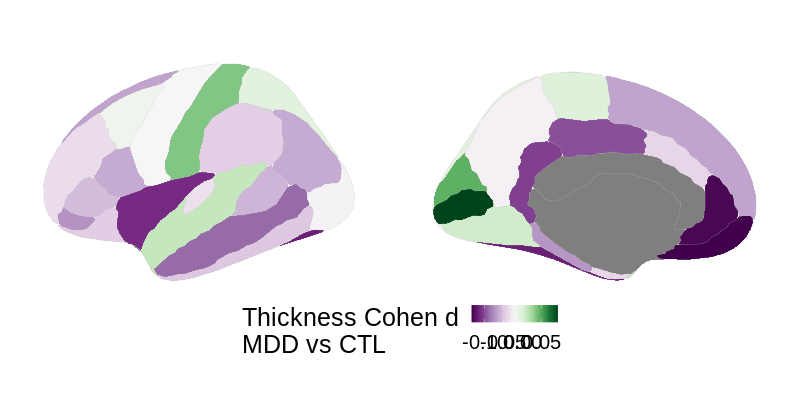

In [178]:
%%R -i dk_mdd -w 800 -h 400

dk$data <- dk$data %>% filter(hemi=='left')

ggplot(dk_mdd) + 
geom_brain(
    atlas=dk,
    mapping=aes(fill=d, geometry=geometry, hemi=hemi, side=side, type=type),
    colour='grey', size=.1,
    show.legend=T
    ) + 
theme_void() +
theme(legend.position='bottom', 
      strip.text.x=element_text(vjust=1),
      plot.title=element_text(hjust=0.5),
      text = element_text(size=25)
     ) +
scale_fill_gradientn(colors=brewer.prgn(100), 
                     # limits=c(-m,m), oob=squish, breaks=c(-m,0,m), 
                     # labels=c(round(-m,2),0,round(m,2)), 
                     name='Thickness Cohen d\nMDD vs CTL'
                    ) + xlab("") + ylab("")

https://stackoverflow.com/questions/37867758/insetting-on-facet-grided-and-grid-arrangeed-plot

Attaching package: ‘gridExtra’



    combine





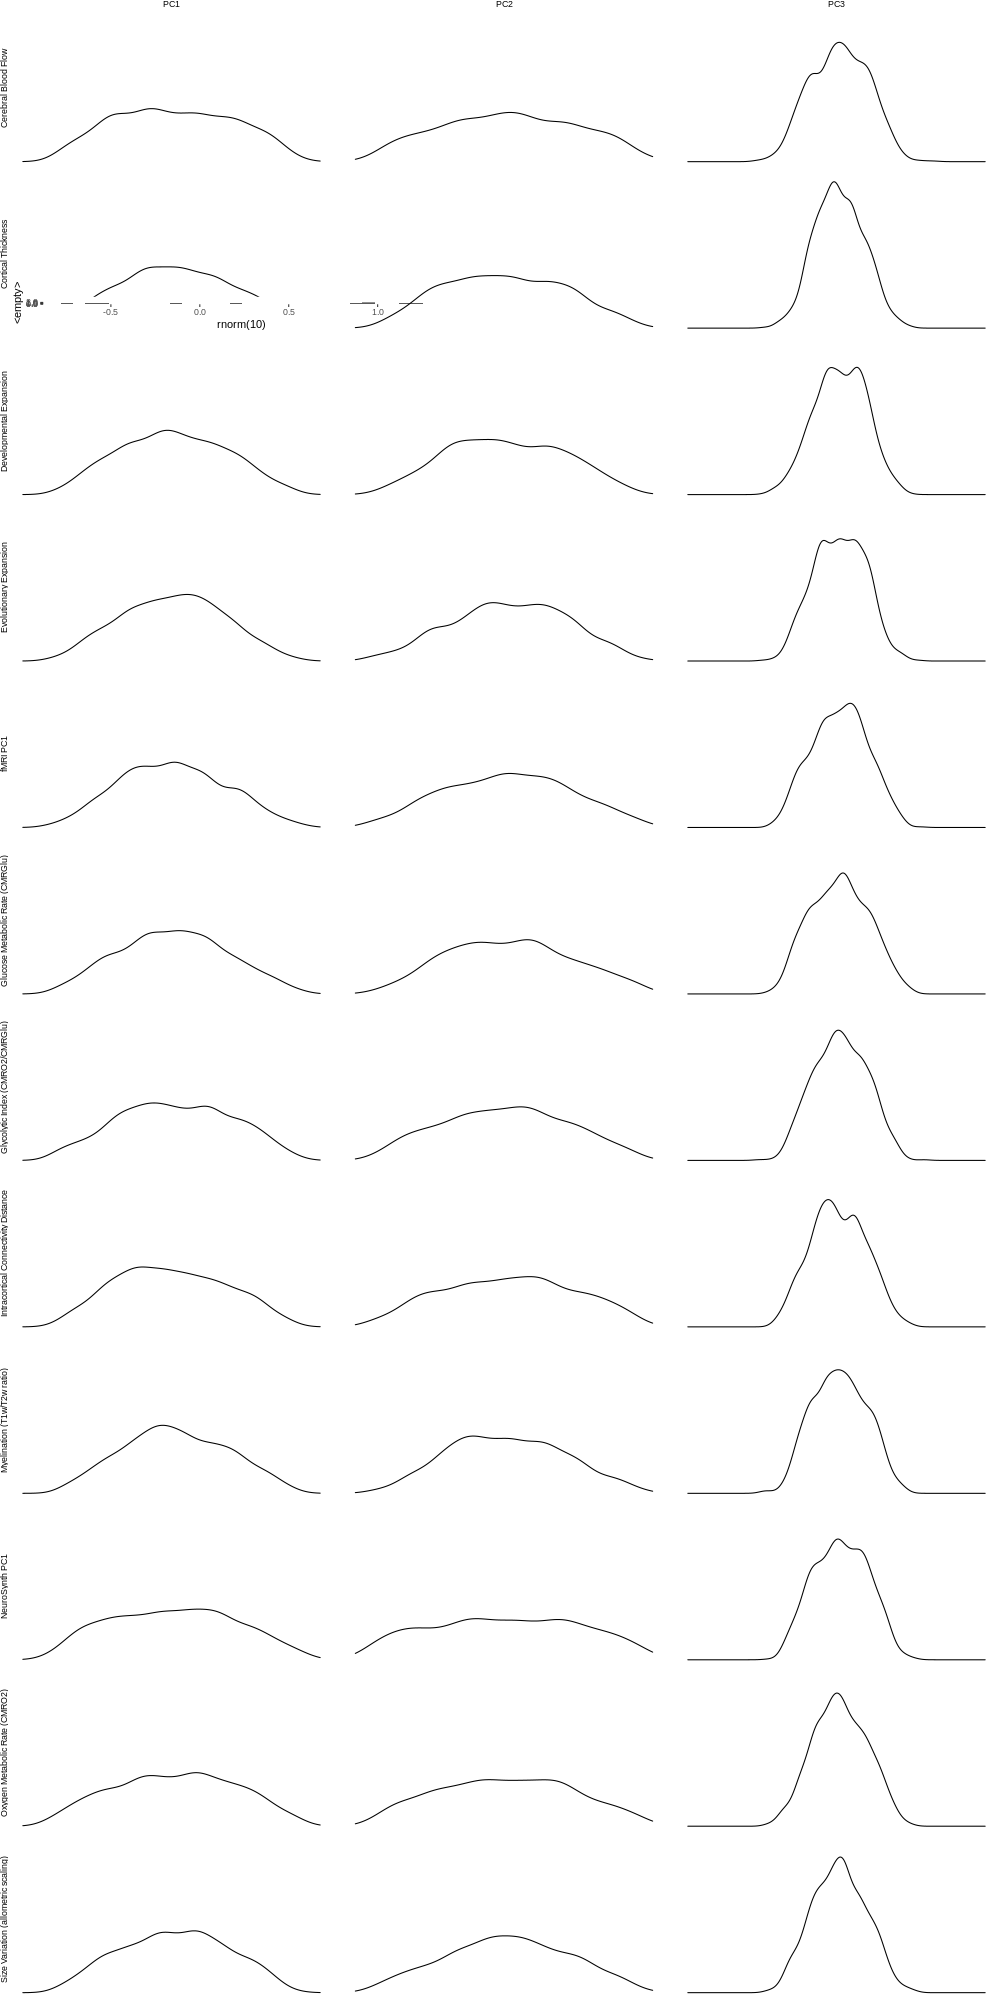

In [24]:
%%R -w 1000 -h 2000 -i scores_plot -i maps -i null_corrs
# source("../code/plot_maps.R")
pcs <- scores_plot %>% gather(pc, pc_score, -label)
maps <- maps %>% rownames_to_column('label') %>% gather(map, map_score, -label)
df_scatter <- maps %>% left_join(pcs, by='label') %>% filter(!is.na(pc))

null_corrs <- null_corrs %>% gather(pc, corr, -map)

library(gridExtra)
annotation_custom2 <- function (grob, xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = Inf, data) 
  {
    layer(data = data, stat = StatIdentity, position = PositionIdentity, 
          geom = ggplot2:::GeomCustomAnn,
          inherit.aes = TRUE, params = list(grob = grob, 
                                            xmin = xmin, xmax = xmax, 
                                            ymin = ymin, ymax = ymax))
  }

inset <- qplot(rnorm(10))


ggplot(data=null_corrs) + 
    facet_grid(map~pc, switch='y') +
    geom_density(aes(corr)) +
    theme_void() + 
    annotation_custom2(ggplotGrob(inset), data=data.frame(map='Cortical Thickness', pc = 'PC1', X=1, Y=1),
                 xmin=-Inf, xmax=1.5, ymin=-Inf, ymax=0.6)

# ggplot(data=df_scatter, aes(x=pc_score, y=map_score)) + 
    # facet_grid(map~pc) + geom_point() + 
    # theme_void() + theme(aspect.ratio=1)